<a href="https://colab.research.google.com/github/tajrink/cisc-3440/blob/main/California_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

This notebook contains a machine learning project designed to predict the median housing price in a given US Census area, called a block. We are given information about housing in the block - for example, its location, the number of households in the block, the population of the block, and so on. Our model must use this information to predict the median housing price.

In [ ]:
# Load the data from a CSV file
df = pd.read_csv("https://raw.githubusercontent.com/CUNY-CISC3440-Fall2022/datasets/main/housing.csv")

In [ ]:
# Briefly review the dataframe to see what kinds of data we have:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
m=df['median_house_value'].median()
m

179700.0

In [ ]:
df["above_median"]=df['median_house_value'].map(lambda x:x>m)

In [ ]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,above_median
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,True
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,True
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,True
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,True
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,True
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,False
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,False
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,False
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,False


In [ ]:
df['above_median'].value_counts()

False    10323
True     10317
Name: above_median, dtype: int64

In [ ]:
df.corr()['above_median'].sort_values(ascending=False)

above_median          1.000000
median_house_value    0.765750
median_income         0.522034
total_rooms           0.127494
households            0.085309
housing_median_age    0.069768
total_bedrooms        0.065903
population           -0.000078
longitude            -0.044482
latitude             -0.139812
Name: above_median, dtype: float64

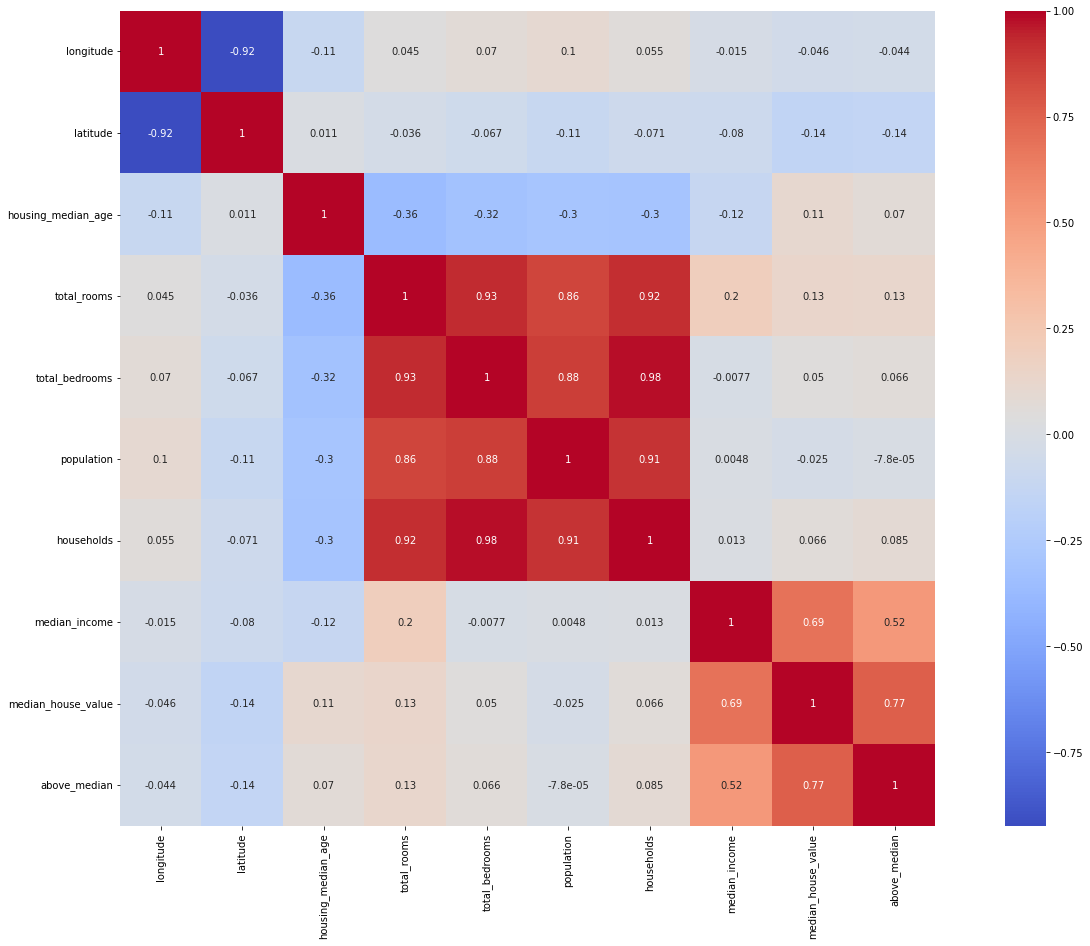

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

In [ ]:
# Get information about the data. There's a problem: total_bedrooms has some null values,
# and the ocean_proximity variable contains a non-numeric type (a string, as we see above)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  above_median        20640 non-null  bool   
dtypes: bool(1), float64(9), object(1)
memory usage: 1.6+ MB


[]

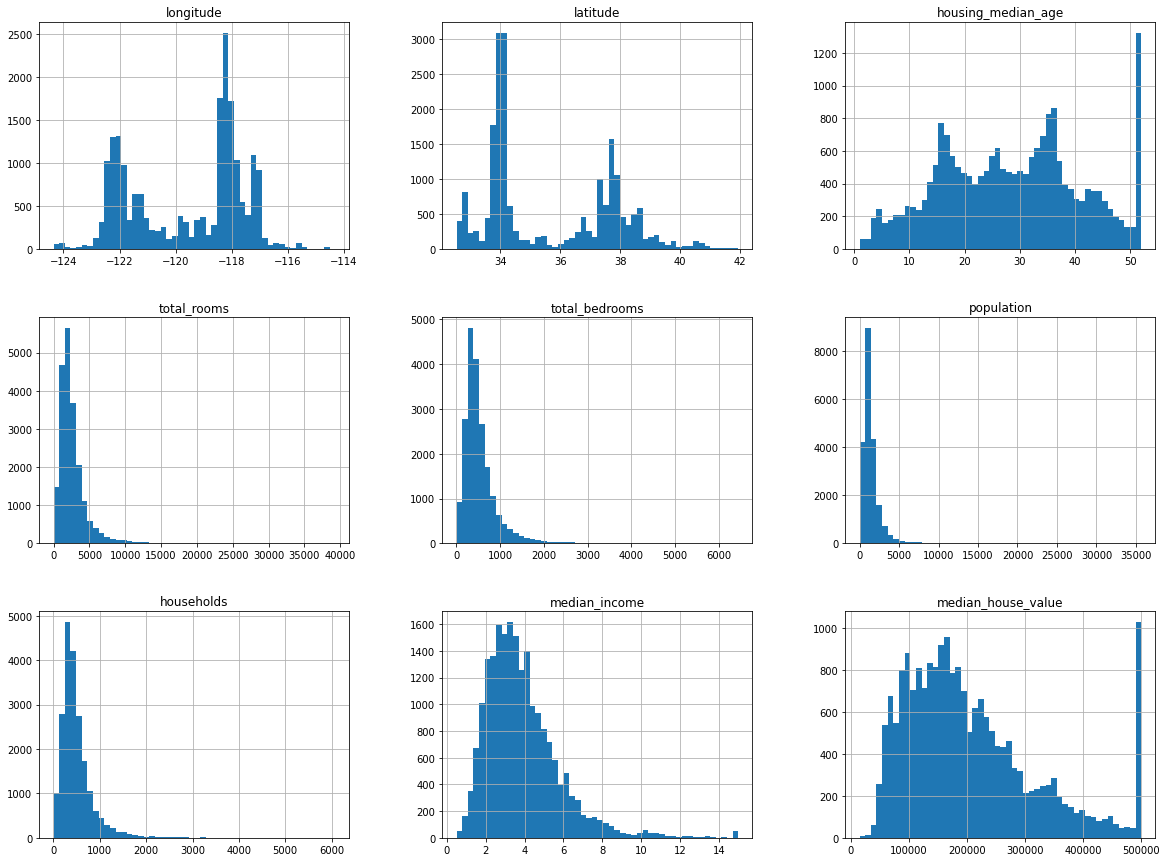

In [ ]:
 # View a histogram of our data. We can get a sense of the range of values
 # contained in each variable, as well as identify potential problems for later.

df.hist(bins=50, figsize=(20,15))
plt.plot()

# From the histogram, we see the following:
#
# - Some variables (housing_median_age, median_house_value) are capped at a
#   maximum value. This could be a problem depending on the needs of the model.
#   For example, do our stakeholders expect us to predict median house values
#   accurately beyond $500,000? If so, we can't with this data!
#       - For now, we will assume it is unnecessary
# - Median income does not appear to be represented as dollars per year. For this
#   dataset, it is actually 1/10,000 of the actual value - for example, a value
#   income of 3 indicates a median income of $30,000. This is just a quirk of
#   this dataset, and we do not need to do anything to fix it.

#Step 2: Visualization

Visualization can help you understand the data better, and can give you insights for how to preprocess the data ore even understand how a machine learning model might learn from your data. We will visualize two aspects of the data below.

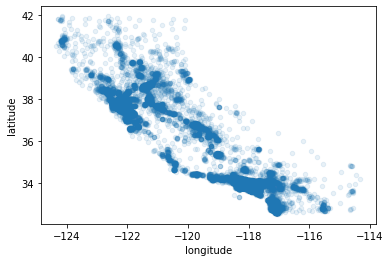

In [ ]:
# The dataset contains location data. What happens if we plot it?
# By adding transparency, we see areas with varying concentrations of
# census blocks - dense areas are darker, and sparsely populated areas
# are lighter. Could dense areas (likely cities) be more expensive than
# sparsely populated areas?
#
# Géron p. 57-58 has a more detailed location visualization revealing
# that our suspicion is true.
df.plot(kind="scatter", x='longitude', y='latitude', alpha=0.1)

[]

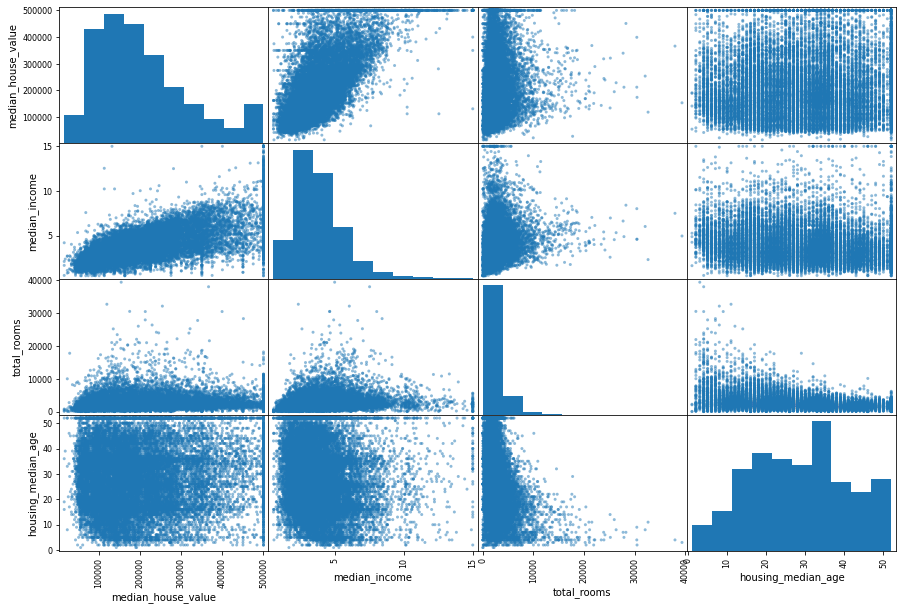

In [ ]:
# Now let's make scatter plots showing the relationship between some of these variables.
# In the plot, we see evidence of the strong positive linear correlation between median
# income and median house value. The rest of the variables confirm what we saw in the
# correlation data above: there are no other variables strongly correlated with median
# house value.
# 
# The book does a deeper look at mean income vs. house value, noting some subtle irregularities
# in the data (60-61)
scatter_matrix(df[['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']], figsize=(15, 10))
plt.plot()

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# The imputer works automatically on all numeric columns. To ensure
# it works, we have to drop non-numeric columns from the dataframe.
imputer.fit_transform(df.drop('ocean_proximity', axis=1))


array([[-1.2223e+02,  3.7880e+01,  4.1000e+01, ...,  8.3252e+00,
         4.5260e+05,  1.0000e+00],
       [-1.2222e+02,  3.7860e+01,  2.1000e+01, ...,  8.3014e+00,
         3.5850e+05,  1.0000e+00],
       [-1.2224e+02,  3.7850e+01,  5.2000e+01, ...,  7.2574e+00,
         3.5210e+05,  1.0000e+00],
       ...,
       [-1.2122e+02,  3.9430e+01,  1.7000e+01, ...,  1.7000e+00,
         9.2300e+04,  0.0000e+00],
       [-1.2132e+02,  3.9430e+01,  1.8000e+01, ...,  1.8672e+00,
         8.4700e+04,  0.0000e+00],
       [-1.2124e+02,  3.9370e+01,  1.6000e+01, ...,  2.3886e+00,
         8.9400e+04,  0.0000e+00]])

## Extra analysis

At this point, the book points out that `total_rooms`, `total_bedrooms`, and `population` are not very useful: who cares how many total rooms or total bedrooms there are in a census block? The number of rooms _per house_ seems like a much more reasonable variable, since it implies _home size_, which intuitively seems related to its price.

We could also compute _bedrooms per room_, giving us a rough idea of how many
families might be expected to live in a single house.

The number of people per house also seems relevant - the total number of people living in each house might have a better correlation with housing price than the total number of people living in a block, although intuitively it isn't clear how strong the correlation is and which direction it might go in.

Pages 61-62 explore this idea, and 68-69, 70 show how to add it to the processing pipeline.

In [ ]:
## Creating useful features
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_household"] = df["total_bedrooms"]/df["households"]
df["population_per_household"] = df["population"]/df["households"]

In [ ]:
df.columns


Index(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'median_house_value', 'above_median',
       'rooms_per_household', 'bedrooms_per_household',
       'population_per_household'],
      dtype='object')

In [ ]:
df = df.drop(columns=['total_rooms','total_bedrooms','population','ocean_proximity'])

# Step 4: Tying it all together

The notebook cells shown above demonstrated different preprocessing steps needed to prepare the data for machine learning _without modifying the original data_. This section actually implements those steps in the form of a sklean transformation pipeline.

This pipeline is adapted from the book, but omits the step where new features are engineered to create rooms per house, bedrooms per house, and population per house. You are encouraged to experiment with creating and omitting these variables and seeing how they impact different ML algorithms!

In [ ]:
# In this cell, we do a simple train/validation split on the training data
# to evaluate our model.

# Define X (inputs) and y (target values) for a machine learning algorithm
X = df
y = df['above_median']

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state=2000)



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#knn classifier

from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_val)
print(confusion_matrix(y_val,pred))


ValueError: ignored

In [ ]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred=rfc.predict(X_val)
print(confusion_matrix(y_val,rfc_pred))

In [ ]:
#support vector classifier
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_val)
svc_conf_matrix = confusion_matrix(y_val, svc_pred)
print("confussion matrix")

In [ ]:
#logistic regressor
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
y_pred = logmodel.predict(X_val)
print(confusion_matrix(y_val,y_pred))
